# Notebook for final thesis

## Imports

Libraries are imported by topic and alphabetical order.

#### Graphics

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

#### Numerical and statistical libraries

In [2]:
import numpy as np
import statsmodels.api as sm
from scipy import stats
from sklearn.cluster import KMeans
from statsmodels.formula.api import ols

#### Dataframes

In [3]:
import pandas as pd

## Pre-processing

Read the dataset.

In [4]:
df = pd.read_excel('Game8.xlsx', sheet_name = 'id_q_offer')

This is our current dataframe. Each row represents a participant. The columns record their anonymous ID, their answers to the LSRP and their ultimatum (referred to as "ultimata"). 

In [5]:
df.head()

,ID,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,...,Q18,Q19,Q20,Q21,Q22,Q23,Q24,Q25,Q26,offer
0,61299,Strongly disagree,Strongly disagree,Strongly disagree,Slightly agree,Strongly disagree,Strongly agree,Strongly disagree,Strongly disagree,Strongly disagree,...,Strongly disagree,Strongly disagree,Slightly disagree,Strongly disagree,Strongly agree,Strongly disagree,Strongly disagree,Slightly agree,Slightly agree,5.0
1,44619,Slightly agree,Strongly agree,Slightly agree,Strongly agree,Slightly agree,Slightly disagree,Slightly agree,Slightly disagree,Strongly disagree,...,Strongly agree,Slightly agree,Slightly disagree,Slightly agree,Slightly disagree,Slightly agree,Strongly agree,Slightly agree,Slightly disagree,10.0
2,81489,Slightly agree,Slightly disagree,Slightly agree,Slightly disagree,Slightly agree,Slightly agree,Strongly agree,Slightly agree,Slightly disagree,...,Slightly disagree,Strongly agree,Slightly disagree,Slightly agree,Strongly agree,Slightly agree,Strongly agree,Slightly agree,Strongly agree,5.0
3,26881,Slightly agree,Strongly agree,Slightly agree,Strongly agree,Slightly agree,Strongly agree,Slightly agree,Strongly agree,Slightly agree,...,Strongly agree,Strongly agree,Slightly agree,Slightly agree,Strongly agree,Slightly agree,Strongly agree,Slightly agree,Strongly agree,9.0
4,10895,Slightly agree,Strongly agree,Slightly agree,Strongly agree,Slightly agree,Strongly agree,Slightly agree,Slightly agree,Strongly agree,...,Slightly agree,Strongly agree,Slightly agree,Strongly agree,Strongly agree,Slightly agree,Strongly agree,Slightly agree,Strongly agree,10.0


In [6]:
df.loc[:,'offer'] = df['offer']/10
df.rename({'offer':'ultimata'}, inplace = True)

Although an option was selected to allow only one completion of the task on MTurk, the following code ensures no ID is repeated.

In [7]:
df_counted = df.groupby('ID').agg({'count'})['Q1']['count']
df_unique_index = []
for i, unq in enumerate(df_counted == 1):
    df_unique_index.append(i)
df = df.iloc[df_unique_index]

Add instructions to the questions (P = primary psychopathy, S = seconday psychopathy, R = reverse scoring). As an example, the column named "Q22PR" refers to a LSRP answer to an item measuring primary psychopathy whose score needs to be reversed.

In [8]:
questions_cols = df[df.columns.values[1:-1]]

In [9]:
df_psrev = pd.read_excel('Game8.xlsx', sheet_name = 'instructions')
cols_instructed = []
cols_instructed.append('ID')
for couple in zip(questions_cols.columns.values, df_psrev['psrev']):
    cols_instructed.append('{}{}'.format(couple[0], couple[1]))
cols_instructed.append('ultimata')
df.columns = cols_instructed

In [10]:
questions_cols = df[df.columns.values[1:-1]]

Here we enconding the answers to the LSRP.

In [11]:
q_encoding = {'Strongly agree': 3, 'Slightly agree': 2, 'Slightly disagree': 1, 'Strongly disagree': 0}
q_encoding_rev = {'Strongly agree': 0, 'Slightly agree': 1, 'Slightly disagree': 2, 'Strongly disagree': 3}

for q in questions_cols:
    if q[-1] == 'R':
        df[q] = df[q].map(q_encoding_rev)
    else:
        df[q] = df[q].map(q_encoding)

The answers are then summed up to a final score.

In [12]:
score = []
for i, q in df[df.columns[1:-1]].iterrows():
    score.append(q.sum())
df['score'] = score
score = np.array(score)

This is our updated dataframe.

In [13]:
df.head()

,ID,Q1P,Q2S,Q3P,Q4S,Q5P,Q6SR,Q7P,Q8S,Q9P,...,Q19PR,Q20S,Q21P,Q22PR,Q23P,Q24PR,Q25PR,Q26PR,ultimata,score
0,61299,0,0,0,2,0,0,0,0,0,...,3,1,0,0,0,3,1,1,0.5,15
1,44619,2,3,2,3,2,2,2,1,0,...,1,1,2,2,2,0,1,2,1.0,42
2,81489,2,1,2,1,2,1,3,2,1,...,0,1,2,0,2,0,1,0,0.5,39
3,26881,2,3,2,3,2,0,2,3,2,...,0,2,2,0,2,0,1,0,0.9,46
4,10895,2,3,2,3,2,0,2,2,3,...,0,2,3,0,2,0,1,0,1.0,48


Let's plot the scores against their respective ultimatas.

In [14]:
sns.set()

The classification into low, neutral and high psychopathic levels is computed.

In [15]:
score_mean = score.mean()
score_sd = score.std()
score_cut = score_mean + score_sd

In [16]:
def psyclass(x, method, classes = None):
    
    classes = []
    
    if method == 'sample':
        for e in x:
            if e <= x.mean():
                classes.append('Low')
            elif e > x.mean() + x.std():
                classes.append('High')
            else:
                classes.append('Neutral')
            
    elif method == 'fixed':
        for e in x:
            if e > 38.95:
                classes.append('High')
            elif e < 34.37:
                classes.append('Low')
            else:
                classes.append('Unaccounted')
                
    return classes

In [17]:
df['Classification'] = psyclass(df['score'], method = 'sample')
df['Fixed Classification'] = psyclass(df['score'], method = 'fixed')

In [18]:
#only primary psychopathy

only_p_columns = []
for q in questions_cols:
    if q.find('P') != -1:
        only_p_columns.append(q)

df_only_p = df[only_p_columns]

resultados_p = []
for i, q in df_only_p.iterrows():
    resultados_p.append(q[1:-1].sum())
resultados_p = np.array(resultados_p)

resultados_media_p = resultados_p.mean()
resultados_sd_p = resultados_p.std()
resultados_corte_p = resultados_media_p + resultados_sd_p

Some preliminary results about the ultimatas according to their respective psycopathic levels.

In [19]:
df_extreme = df[df['Classification'] != 'Neutral']
df_extreme_low = df_extreme[df_extreme['Classification'] == 'Low']
df_extreme_high = df_extreme[df_extreme['Classification'] == 'High']
df_neutral = df[df['Classification'] == 'Neutral']

In [20]:
df_mean_sd_ultimata = ['Low', df_extreme_low['ultimata'].mean(), df_extreme_low['ultimata'].std(), df_extreme_low['ultimata'].kurtosis()], \
             ['Neutral', df_neutral['ultimata'].mean(), df_neutral['ultimata'].std(), df_neutral['ultimata'].kurtosis()], \
             ['High', df_extreme_high['ultimata'].mean(), df_extreme_high['ultimata'].std(), df_extreme_high['ultimata'].kurtosis()], \
             ['All', df['ultimata'].mean(), df['ultimata'].std(), df['ultimata'].kurtosis()]


df_summary_ultimata = pd.DataFrame(df_mean_sd_ultimata, columns = ['Classification', 'Mean', 'SD', 'Kurtosis'])
df_summary_ultimata

,Classification,Mean,SD,Kurtosis
0,Low,0.419130,0.250226,-0.000699
1,Neutral,0.541875,0.277562,-0.860292
2,High,0.638213,0.272508,-0.184678
3,All,0.509297,0.276771,-0.752394


In [21]:
df_mean_sd_score = ['Low', df_extreme_low['score'].mean(), df_extreme_low['score'].std(),
                    df_extreme_low['score'].kurtosis()], \
                   ['Neutral', df_neutral['score'].mean(), df_neutral['score'].std(),
                    df_neutral['score'].kurtosis()], \
                   ['High', df_extreme_high['score'].mean(), df_extreme_high['score'].std(),
                    df_extreme_high['score'].kurtosis()], \
                   ['All', df['score'].mean(), df['score'].std(), df['score'].kurtosis()]


df_summary_score = pd.DataFrame(df_mean_sd_score, columns = ['Classification', 'Mean', 'SD', 'Kurtosis'])
df_summary_score

,Classification,Mean,SD,Kurtosis
0,Low,21.947826,8.616430,-1.034117
1,Neutral,43.618750,3.862205,-1.126146
2,High,53.050000,2.111628,-0.547015
3,All,36.904762,13.159379,-0.612353


In [22]:
ohos_sim = stats.norm.rvs(loc = 34.37, scale = 4.58, size = 700)

In [23]:
stats.ttest_ind(ohos_sim, score, permutations = 10000, random_state = 42)[1]

0.0

Moreover, based on descriptive statistics of the scorefor 700 students (M= 34.37,SD= 4.58), each students scoring over38.95 and below 34.37 were assigned to the high psychopathicgroup and the low psychopathic (non-psychopathic) group, respec-tively. The scores on the primary psychopathy scale were 39–48(M= 42.17,SD= 3.04) for the high psychopathic group and 20–34(M= 30.19,SD= 3.92) for the low group. 

In [24]:
class individual_deviation():
    def plain(x):
        return [i - x.mean() for i in x]
    def absolute(x):
        return [np.abs(i - x.mean()) for i in x]
    def squared(x):
        return [(i - x.mean())**2 for i in x]
    def log(x):
        return [np.log((i - x.mean())) for i in x]

In [25]:
font_specs = {'fontname':'Arial', 'fontsize':12}

In [26]:
individual_pal = ['deeppink', '#FFD800', 'dodgerblue']

In [27]:
# ind_values = np.unique(ind_dev_score, return_counts=True)[0]
# ind_counts = np.unique(ind_dev_score, return_counts=True)[1]
# ind_freq = ind_counts*100/len(ind_counts)

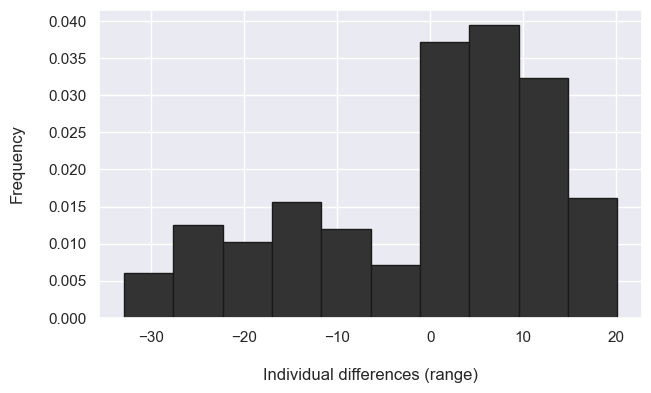

In [28]:
fig1, ax1 = plt.subplots(figsize = (7, 4))

ind_dev_score = individual_deviation.plain(df['score'])

sns.histplot(x = ind_dev_score, color = '#333333', edgecolor = 'k', alpha = 1, stat = 'density')

# for loc in locators:
#     plt.text(loc[0] + 2, loc[1] + 1.5, loc[1], fontsize = 11)

#plt.title('Frequency of individual score differences\n', **font_specs)
plt.xlabel('\nIndividual differences (range)', **font_specs)
plt.ylabel('Frequency\n', **font_specs)

plt.savefig('Frequency of individual score differences.png', bbox_inches = 'tight', dpi = 300)

In [29]:
min(individual_deviation.plain(df_extreme_high['score'])), max(individual_deviation.plain(df_extreme_high['score']))

(-2.049999999999997, 3.950000000000003)

In [30]:
min(individual_deviation.plain(df_extreme_high['score'])), max(individual_deviation.plain(df_extreme_high['score']))

(-2.049999999999997, 3.950000000000003)

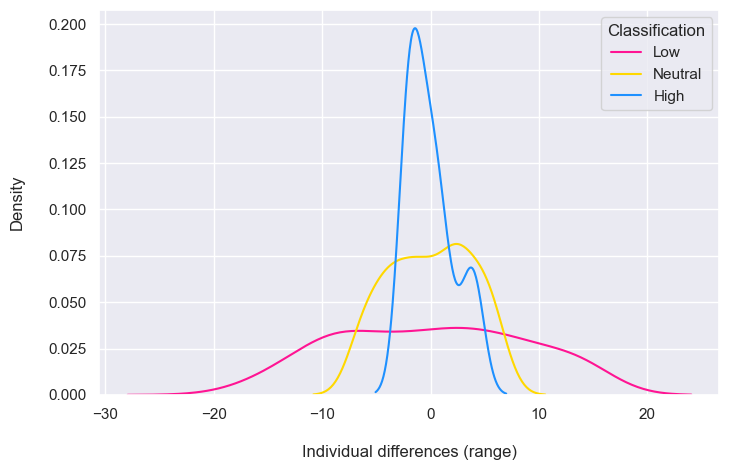

In [31]:
fig2, ax2 = plt.subplots(figsize = (8, 5))

sns.kdeplot(individual_deviation.plain(df_extreme_low['score']), color = individual_pal[0], label = 'Low')
sns.kdeplot(individual_deviation.plain(df_neutral['score']), color = individual_pal[1], label = 'Neutral')
sns.kdeplot(individual_deviation.plain(df_extreme_high['score']), color = individual_pal[2], label = 'High')

#plt.title('Density of individual score differences by group\n', **font_specs)
plt.legend(title = 'Classification')
plt.xlabel('\nIndividual differences (range)', **font_specs)
plt.ylabel('Density\n', **font_specs)

plt.savefig('Density of individual score differences by group.png', bbox_inches = 'tight', dpi = 300)

Let's plot the density of scores against ultimatas, the former classified by low, neutral and high psycopathic levels.

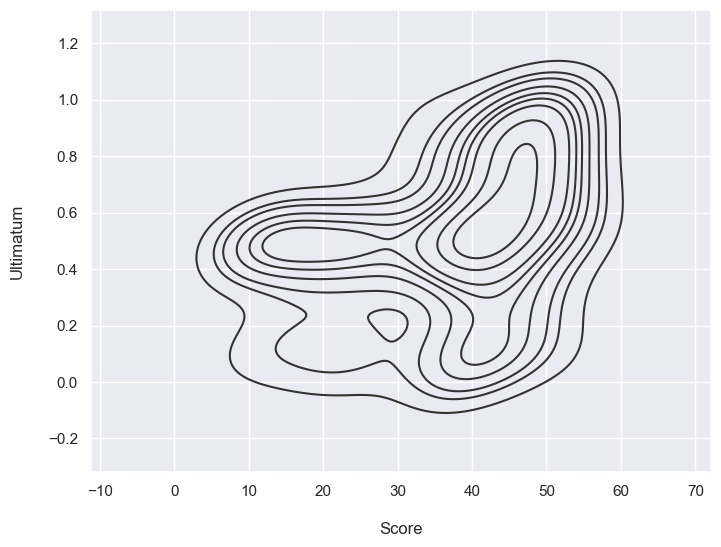

In [32]:
fig3, ax3 = plt.subplots(figsize = (8, 6))

g = sns.kdeplot(
    data = df,
    x = 'score',
    y = 'ultimata',
    thresh = .1,
    color = '#333333')

#plt.title('Sample density of scores vs. ultimata\n', **font_specs)
plt.xlabel('\nScore', **font_specs)
plt.ylabel('Ultimatum\n', **font_specs)

plt.savefig('Sample density of scores vs. ultimata.png', bbox_inches = 'tight', dpi = 300)

In [33]:
df.query('Classification == "Neutral"')['ultimata'].min(), df.query('Classification == "Neutral"')['ultimata'].max()

(0.0, 1.0)

In [34]:
df.query('Classification == "High"')['ultimata'].min(), df.query('Classification == "High"')['ultimata'].max()

(0.01, 1.0)

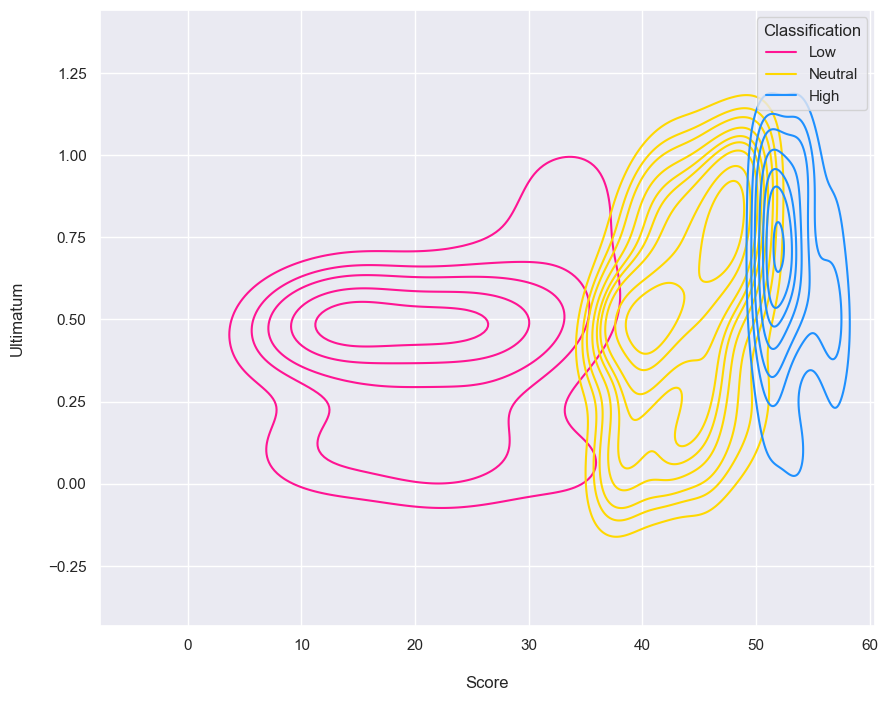

In [35]:
fig4, ax4 = plt.subplots(figsize = (10, 8))

sns.kdeplot(
    data = df,
    x = 'score',
    y = 'ultimata',
    hue = 'Classification',
    thresh = .1,
    palette = individual_pal)

#plt.title('Density of scores vs. ultimata by group\n')
plt.xlabel('\nScore', **font_specs)
plt.ylabel('Ultimatum\n', **font_specs)

plt.savefig('Density of scores vs. ultimata by group.png', bbox_inches = 'tight', dpi = 300)

The next endeavor is to access the distributions of scores.

In [36]:
score_count = df.groupby(['score']).agg({'count'})['ID']['count'].reset_index().copy() #ID is arbitrary

score_count['Probability'] = [i/df.shape[0] for i in score_count['count']]
        
score_count['Classification'] = psyclass(score_count['score'], method = 'sample')

The `score_count` dataframe records each unique score and their counts, probabilities and respective classification.

In [37]:
# paired_scores = np.split(np.array(score_count.iloc[:-1]['score']), score_count.shape[0] // 2)
# paired_scores_tails = []
# for pair in paired_scores:
#     paired_scores_tails.append(pair[1])
# paired_scores_tails.append(score_count.iloc[-1]['score'])

# paired_class = np.split(np.array(score_count.iloc[:-1]['Classification']), score_count.shape[0] // 2)
# paired_class_tails = []
# for pair in paired_class:
#     paired_class_tails.append(pair[1])
# paired_class_tails.append(score_count.iloc[-1]['Classification'])

# paired_counts = list(score_count.iloc[:-1]['count'].groupby(score_count.iloc[:-1].index // 2).sum())
# paired_counts.append(score_count.iloc[-1]['count'])

# paired_freqs = [i/sum(paired_counts) for i in paired_counts]

# paired_df = pd.DataFrame([paired_scores_tails, paired_counts, paired_freqs, paired_class_tails]).T
# paired_df.rename(columns = {0:'Score', 1:'Counts', 2:'Frequencies', 3:'Classification'}, inplace = True)
# paired_df.head()

In [38]:
#count_results['resultados_sq'] = [np.sqrt(i) for i in count_results['resultados']]
#count_results['resultados_log'] = [np.log(i) for i in count_results['resultados']]
#count_results['resultados_power'] = [i**2 for i in count_results['resultados']]

In [39]:
score_count.head()

,score,count,Probability,Classification
0,4,1,0.003175,Low
1,6,1,0.003175,Low
2,7,1,0.003175,Low
3,8,3,0.009524,Low
4,9,4,0.012698,Low


Let's plot the results.

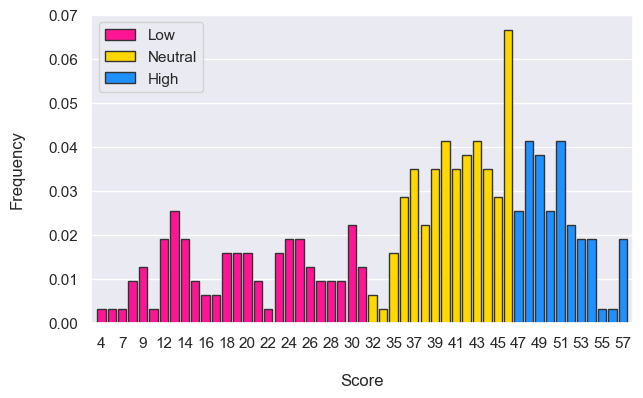

In [40]:
fig7, ax7 = plt.subplots(figsize = (7, 4))

sns.barplot(data = score_count,
             x = 'score',
             y = 'Probability',
             hue = 'Classification',
             palette = individual_pal,
             edgecolor = '#333333',
             saturation = 1,
             dodge = False)

for index, label in enumerate(ax7.get_xticklabels()):
    if index % 2 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

#plt.title('Distribution of scores by group\n', **font_specs)
plt.xlabel('\nScore', **font_specs)
plt.ylabel('Frequency\n', **font_specs)
plt.legend(loc = 'upper left')

xlim = ax7.get_xlim()
plt.xlim(xlim[0] - 0.5, xlim[1] + 0.5)

plt.savefig('Distribution of scores by group.png', bbox_inches = 'tight', dpi = 300)

Does K-clustering add something to the table?

In [45]:
df_cluster = df[['score', 'ultimata']]

clusters = KMeans(2, random_state = 0).fit_predict(df_cluster)

inv_clusters = []
for cluster in clusters:
    if cluster == 0:
        inv_clusters.append(1)
    else:
        inv_clusters.append(0)

df['Cluster'] = inv_clusters

The algorithm seems to have splitted the scores into low and high, with cluster 0 absorbing low psychopathy and cluster 1 absorbing neutral and high psychopathy. Let's visualize it.

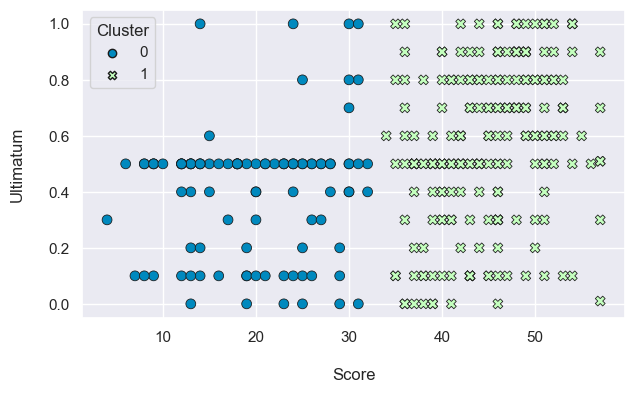

In [46]:
fig8, ax8 = plt.subplots(figsize = (7, 4))

sns.scatterplot(data = df, x = 'score', y = 'ultimata', hue = 'Cluster', style = 'Cluster',
                palette = ['#0089BE', '#C4FFBE'], edgecolor = 'k', s = 50)

handles, labels = ax8.get_legend_handles_labels()

for ha in handles:
    ha.set_edgecolor('k')

ax8.legend(handles, 
           labels,
           loc = 'upper left',
           title = 'Cluster')

#plt.title('Scores vs ultimata by cluster\n', **font_specs)
plt.xlabel('\nScore', **font_specs)
plt.ylabel('Ultimatum\n', **font_specs)

plt.savefig('Scores vs ultimata by cluster.png', bbox_inches = 'tight', dpi = 300)

C:\Users\unit0\anaconda3\lib\site-packages\seaborn\distributions.py:1210: UserWarning: The following kwargs were not used by contour: 'edgecolor'
  cset = contour_func(


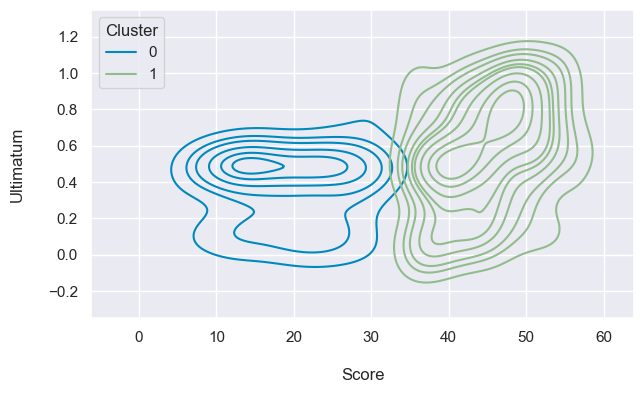

In [47]:
fig9, ax9 = plt.subplots(figsize = (7, 4))

h = sns.kdeplot(
    data=df,
    x="score",
    y="ultimata",
    hue="Cluster",
    thresh=.1,
    palette = ['#0089BE', '#92BC8D'],
    edgecolor = 'k')

h_title = 'Cluster'
h.legend_.set_title(h_title)
sns.move_legend(h, 'upper left')

#plt.title('Density of scores vs. ultimata by cluster\n', **font_specs)
plt.xlabel('\nScore', **font_specs)
plt.ylabel('Ultimatum\n', **font_specs)

plt.savefig('Density of scores vs. ultimata by cluster.png', bbox_inches = 'tight', dpi = 300)

We discount the mean from the ultimata and then get its absolute value. We perform a regression for both instances.

In [48]:
x = df['score']
y = df['ultimata']

yminus = df['ultimata'] - y.mean()
yabs = np.abs(yminus)

df_ols = pd.DataFrame()
df_ols['x'] = x
df_ols['y'] = y
df_ols['yminus'] = yminus
df_ols['yabs'] = yabs

plain_xy = ols('y ~ x', data = df_ols).fit(cov_type = 'HC3')
minus_xy = ols('yminus ~ x', data = df_ols).fit(cov_type = 'HC3')
abs_xy = ols('yabs ~ x', data = df_ols).fit(cov_type = 'HC3')

x_with_const = sm.add_constant(x)
plain_res = sm.OLS(y, x_with_const).fit(cov_type = 'HC3')
minus_res = sm.OLS(yminus, x_with_const).fit(cov_type = 'HC3')
abs_res = sm.OLS(yabs, x_with_const).fit(cov_type = 'HC3')

The results are summarized and plotted below.

In [49]:
import statsmodels.stats.api as sms

In [50]:
sms.het_breuschpagan(plain_xy.resid, plain_xy.model.exog)[1]

0.015590307321417427

In [51]:
sms.het_breuschpagan(minus_xy.resid, minus_xy.model.exog)[1]

0.015590307321416797

In [52]:
sms.het_breuschpagan(abs_xy.resid, abs_xy.model.exog)[1]

0.022473405879221853

In [53]:
plain_xy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     47.58
Date:                Thu, 16 Mar 2023   Prob (F-statistic):           2.92e-11
Time:                        20:33:08   Log-Likelihood:                -23.241
No. Observations:                 315   AIC:                             50.48
Df Residuals:                     313   BIC:                             57.99
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.2503      0.038      6.625      0.000       0.176       0.324
x              0.0070      0.001      6.898      0.000       0.005       0.009
==============================================================================
Omnibus:                        9.937   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                7.475
Skew:                          -0.269   Prob(JB):                       0.0238
Kurtosis:                       2.471   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

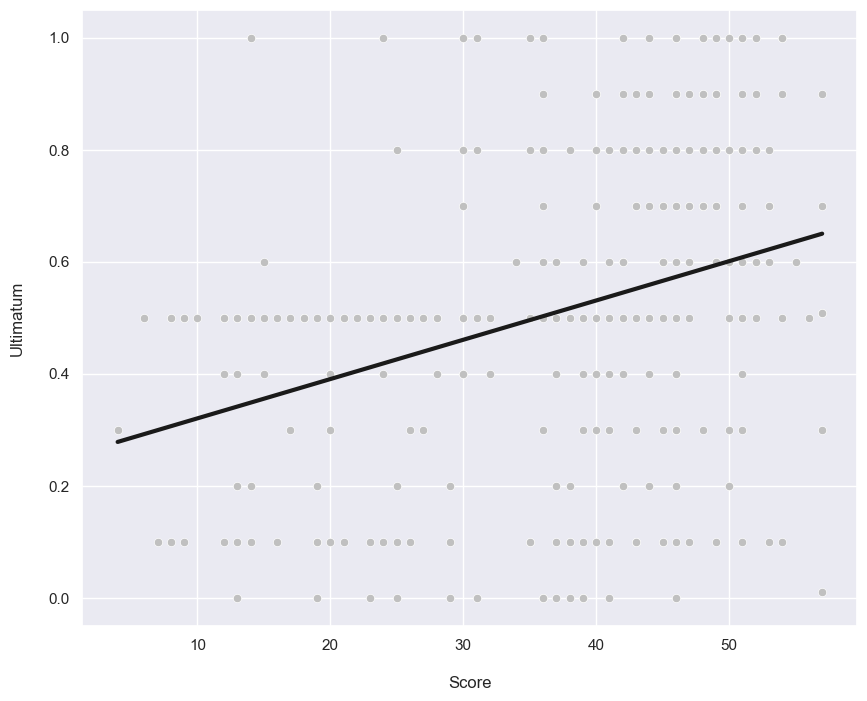

In [54]:
fig_ols, x_ols = plt.subplots(figsize = (10, 8))

ypred = plain_xy.predict(pd.DataFrame(x))

sns.scatterplot(x = x, y = y, color = 'silver')
sns.lineplot(x = x, y = ypred, color = 'k', linewidth = 3)

#plt.title('OLS: scores vs ultimata\n', **font_specs)
plt.xlabel('\nScore', **font_specs)
plt.ylabel('Ultimatum\n', **font_specs)

plt.savefig('OLS scores vs ultimata.png', bbox_inches = 'tight', dpi = 300)

In [55]:
minus_xy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 yminus   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     47.58
Date:                Thu, 16 Mar 2023   Prob (F-statistic):           2.92e-11
Time:                        20:33:10   Log-Likelihood:                -23.241
No. Observations:                 315   AIC:                             50.48
Df Residuals:                     313   BIC:                             57.99
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.2590      0.038     -6.854      0.000      -0.333      -0.185
x              0.0070      0.001      6.898      0.000       0.005       0.009
==============================================================================
Omnibus:                        9.937   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.007   Jarque-Bera (JB):                7.475
Skew:                          -0.269   Prob(JB):                       0.0238
Kurtosis:                       2.471   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

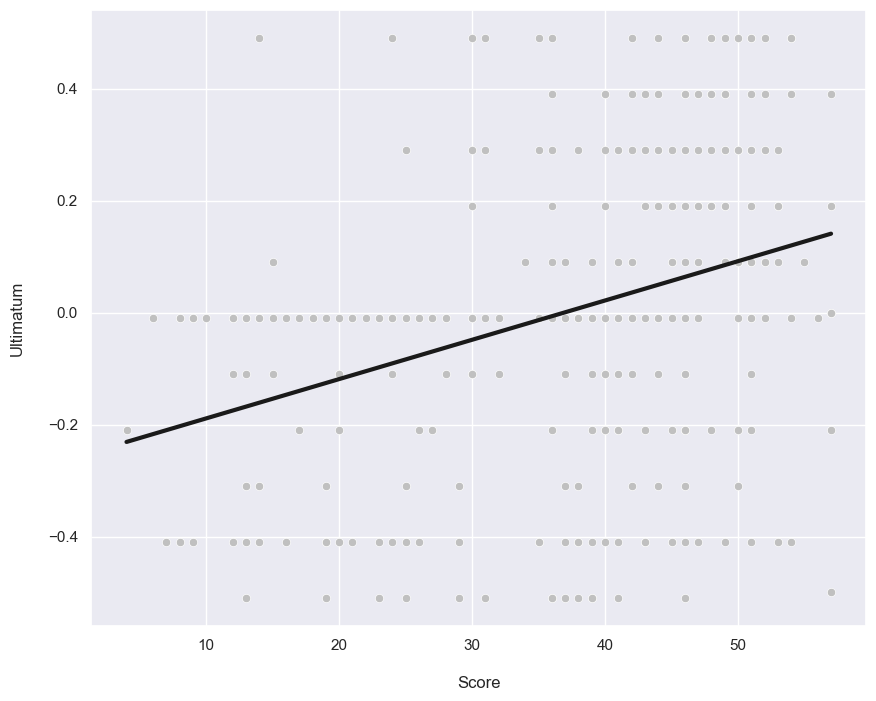

In [56]:
fig_minus, ax_minus = plt.subplots(figsize = (10, 8))
plt.savefig('OLS scores vs ultimata.png', bbox_inches = 'tight', dpi = 300)

ypred_minus = minus_xy.predict(pd.DataFrame(x))

sns.scatterplot(x = x, y = yminus, color = 'silver')
sns.lineplot(x = x, y = ypred_minus, color = 'k', linewidth = 3)

#plt.title('OLS: scores vs ultimata (mean discounted)\n', **font_specs)
plt.xlabel('\nScore', **font_specs)
plt.ylabel('Ultimatum\n', **font_specs)

plt.savefig('OLS scores vs ultimata (mean discounted).png', bbox_inches = 'tight', dpi = 300)

In [57]:
abs_xy.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   yabs   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     12.74
Date:                Thu, 16 Mar 2023   Prob (F-statistic):           0.000414
Time:                        20:33:12   Log-Likelihood:                 107.54
No. Observations:                 315   AIC:                            -211.1
Df Residuals:                     313   BIC:                            -203.6
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1137      0.031      3.711      0.000       0.054       0.174
x              0.0027      0.001      3.569      0.000       0.001       0.004
==============================================================================
Omnibus:                      219.646   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               25.168
Skew:                           0.316   Prob(JB):                     3.43e-06
Kurtosis:                       1.768   Cond. No.                         117.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

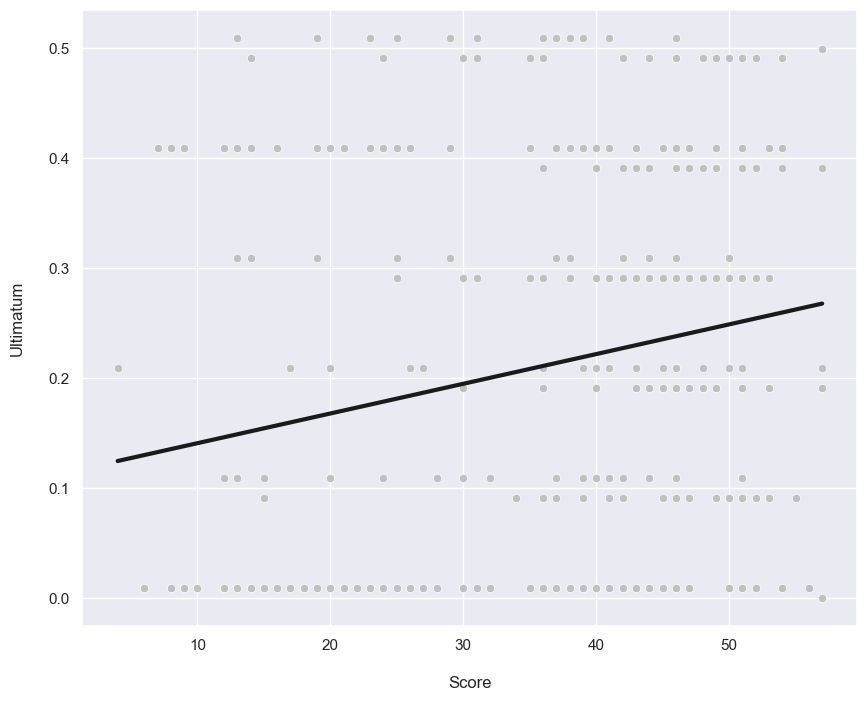

In [58]:
fig_abs, ax_abs = plt.subplots(figsize = (10, 8))

ypred_abs = abs_xy.predict(pd.DataFrame(x))

sns.scatterplot(x = x, y = yabs, color = 'silver')
sns.lineplot(x = x, y = ypred_abs, color = 'k', linewidth = 3)

#plt.title('OLS: scores vs ultimata (absolute value with mean discounted)\n', **font_specs)
plt.xlabel('\nScore', **font_specs)
plt.ylabel('Ultimatum\n', **font_specs)

plt.savefig('OLS scores vs ultimata (absolute value with mean discounted).png', bbox_inches = 'tight', dpi = 300)